In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


**Import and Read Files**

In [4]:
customer = pd.read_csv("Customer.csv", delimiter=';')
product = pd.read_csv('Product.csv', delimiter = ';')
store = pd.read_csv('Store.csv', delimiter = ';')
transaction = pd.read_csv('Transaction.csv', delimiter = ';')

In [5]:
customer.shape, product.shape, store.shape, transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [6]:
customer.info(), product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


(None, None)

In [7]:
store.info(), transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-n

(None, None)

In [8]:
customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

Drop column who has empty value

In [9]:
customer = customer.dropna()

Replace ',' with '.' to be able to be read as float

In [10]:
customer.loc[:,'Income'] = customer['Income'].replace(',','.', regex = True).astype('float')
customer

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57
...,...,...,...,...,...
441,442,42,1,Married,14.88
443,444,53,0,Married,15.31
444,445,51,0,Married,14.48
445,446,57,0,Married,7.81


In [11]:
product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [12]:
product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [13]:
store.sample()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"


In [14]:
store['Latitude'] = store['Latitude'].replace(',','.', regex = True).astype('float')
store['Longitude'] = store['Longitude'].replace(',','.', regex = True).astype('float')
store.sample()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
10,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403


In [15]:
transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [16]:
transaction.sample()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
861,TR83,293,02/03/2022,P5,4200,3,12600,13


In [17]:
transaction['Date'] = pd.to_datetime(transaction['Date'], format = '%d/%m/%Y')
transaction.sample()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1207,TR60337,375,2022-03-26,P4,12000,4,48000,14


In [18]:
df_merge = pd.merge(customer, transaction, on = ['CustomerID'])
df_merge = pd.merge(df_merge, store, on = ['StoreID'])
df_merge = pd.merge(df_merge, product.drop(columns = ['Price']), on = ['ProductID'])
df_merge = df_merge.sort_values(by='Date').reset_index(drop = True)
df_merge.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,328,36,0,Married,10.53,TR11369,2022-01-01,P3,7500,4,30000,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
1,386,33,0,Married,6.95,TR41231,2022-01-01,P9,10000,1,10000,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664,Yoghurt
2,123,34,0,Married,4.36,TR99839,2022-01-01,P2,3200,6,19200,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Ginger Candy
3,283,19,1,Single,0.0,TR51675,2022-01-01,P10,15000,1,15000,5,Bonafid,Gita,General Trade,-7.250445,112.768845,Cheese Stick
4,51,36,0,Married,7.95,TR54287,2022-01-01,P8,16000,2,32000,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238,Oat


**ARIMA**

Merge Quantity and Sum into one table using .agg and reset index by date

In [19]:
df_regression = df_merge.groupby(['Date']).agg({'Qty':'sum'}).reset_index()
df_regression

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


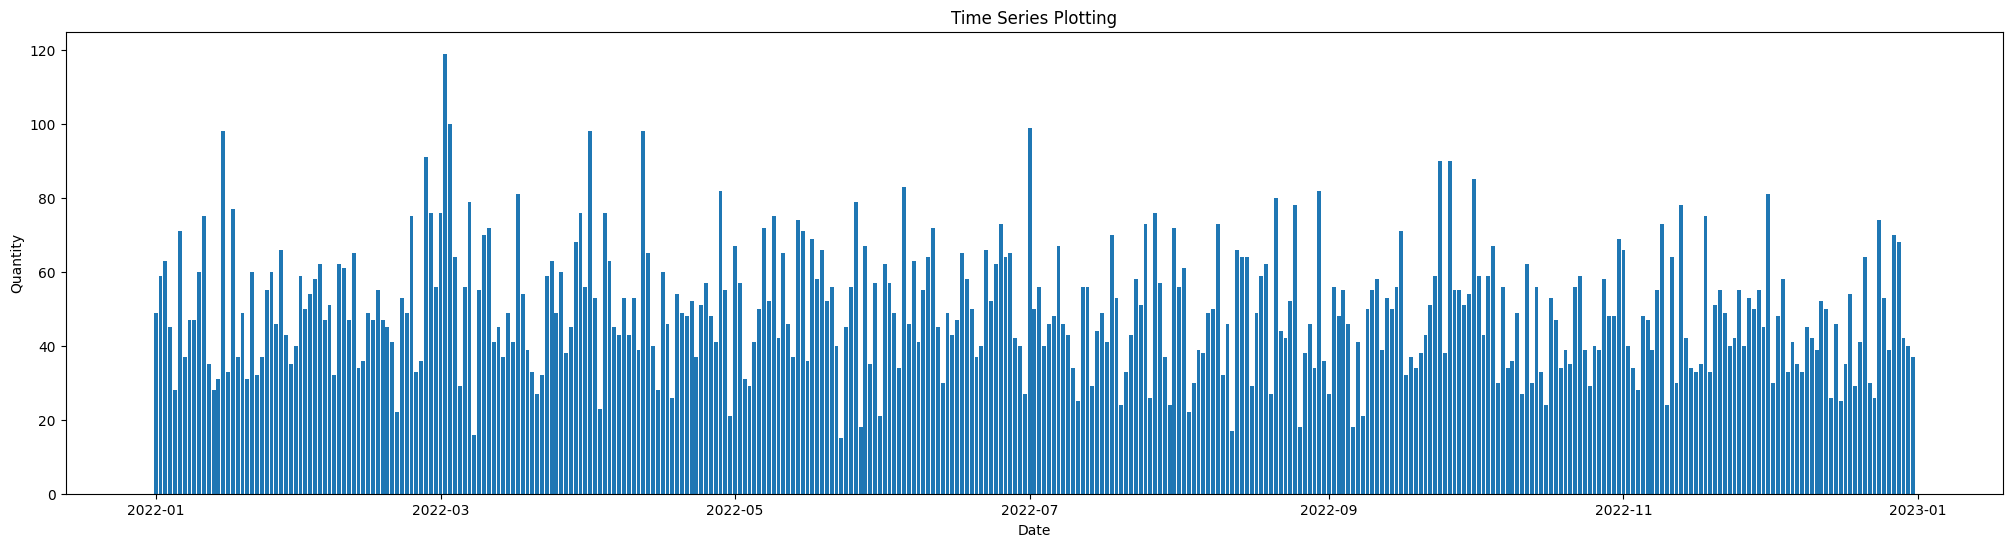

In [20]:
plt.figure(figsize = (25,6))
plt.bar(df_regression['Date'], df_regression['Qty'])


plt.title('Time Series Plotting')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

Data Trend & Seosanality

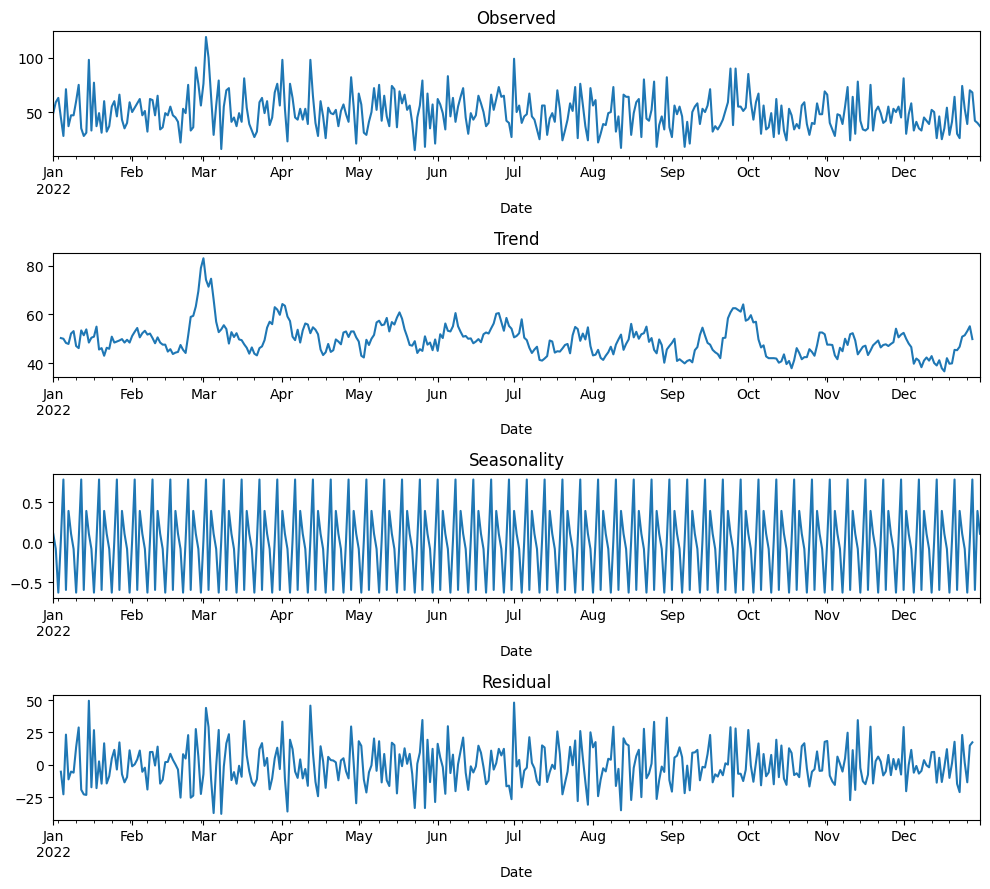

In [21]:
#Set date as index
reg_decompose = seasonal_decompose(df_regression.set_index('Date'))

plt.figure(figsize = (10,9))

#Observed Subplot
plt.subplot(411)
reg_decompose.observed.plot(ax = plt.gca())
plt.title('Observed')

#Trend Subplot
plt.subplot(412)
reg_decompose.trend.plot(ax = plt.gca()) #specifies the current axis for plotting
plt.title('Trend')

#Seasonality Subplot
plt.subplot(413)
reg_decompose.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')

#Residual Subplot
plt.subplot(414)
reg_decompose.resid.plot(ax = plt.gca())
plt.title('Residual')


plt.tight_layout()

**Data Stationarity Check**

Here we check if our data is stationary or no.

H0 = Data is not stationary

H1 = data is stationary


α = 0.05

In [22]:
res = adfuller(df_regression['Qty'])

print('ADF Statistic: %f' % res[0])
print('p-value: %.2f' % res[1])
print('Critical Values:')
for key, value in res[4].items():
  print('%s: %.3f' % (key, value))

if (res[1]) <= 0.05:
    print('\n Reject the null hypothesis (H0), data is stationary')
else:
    print('\n Fail to reject the null hypothesis (H0), data is not stationary')

ADF Statistic: -19.248302
p-value: 0.00
Critical Values:
1%: -3.448
5%: -2.870
10%: -2.571

 Reject the null hypothesis (H0), data is stationary



Autocorrelation is the correlation of random variables or data against itself at different points in time (lags). 

We use autocorrelation to measure the correlation of a time series with a lagged version of itself. This computation allows us to gain some interesting insight into the characteristics of our series, such as seasonality and trend.

Unlike autocorrelation, partial autocorrelation (PACF) hasn’t got as my uses for time series analysis. However, its main and very important impact comes in when building forecasting models.

The PACF is used to estimate the number/order of autoregressive components when fitting (in this case) ARIMA models



Text(0, 0.5, 'Correlation')

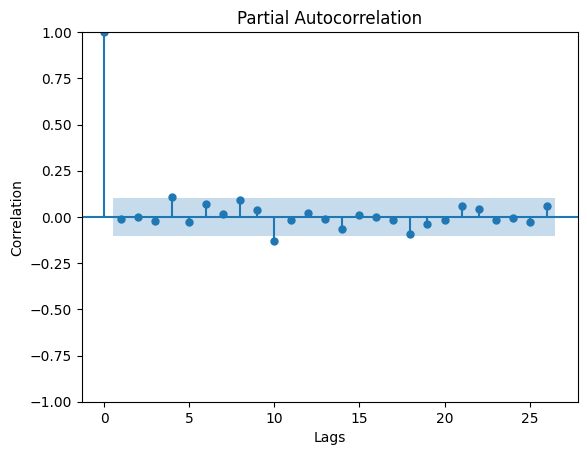

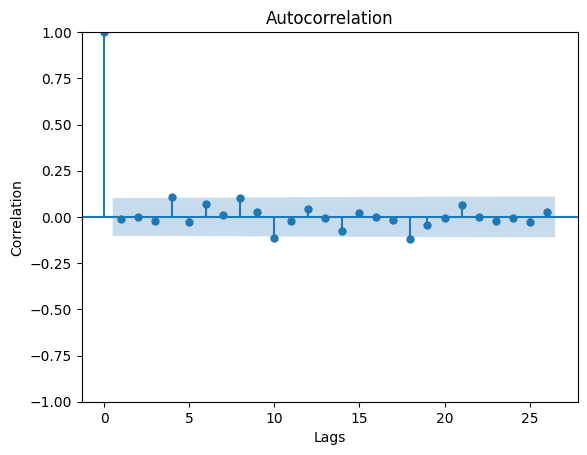

In [23]:
original_pacf = plot_pacf(df_regression['Qty'])
plt.xlabel('Lags')
plt.ylabel('Correlation')

original_acf = plot_acf(df_regression['Qty'])
plt.xlabel('Lags')
plt.ylabel('Correlation')


We see that lag 0 is highly correlated and there are other highly correlated lags later in time which are probably due to seasonal affects.

Split Data:
85% Training, 15% Testing

In [24]:
split_size = round(df_regression.shape[0] * 0.85)
data_train = df_regression[:split_size]
data_test = df_regression[split_size:].reset_index(drop = True)
data_train.shape, data_test.shape

((310, 2), (55, 2))

In [25]:
data_test

,Date,Qty
0,2022-11-07,39
1,2022-11-08,55
2,2022-11-09,73
3,2022-11-10,24
4,2022-11-11,64
5,2022-11-12,30
6,2022-11-13,78
7,2022-11-14,42
8,2022-11-15,34
9,2022-11-16,33


In [26]:
data_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28
...,...,...
305,2022-11-02,40
306,2022-11-03,34
307,2022-11-04,28
308,2022-11-05,48


<Axes: xlabel='Date', ylabel='Qty'>

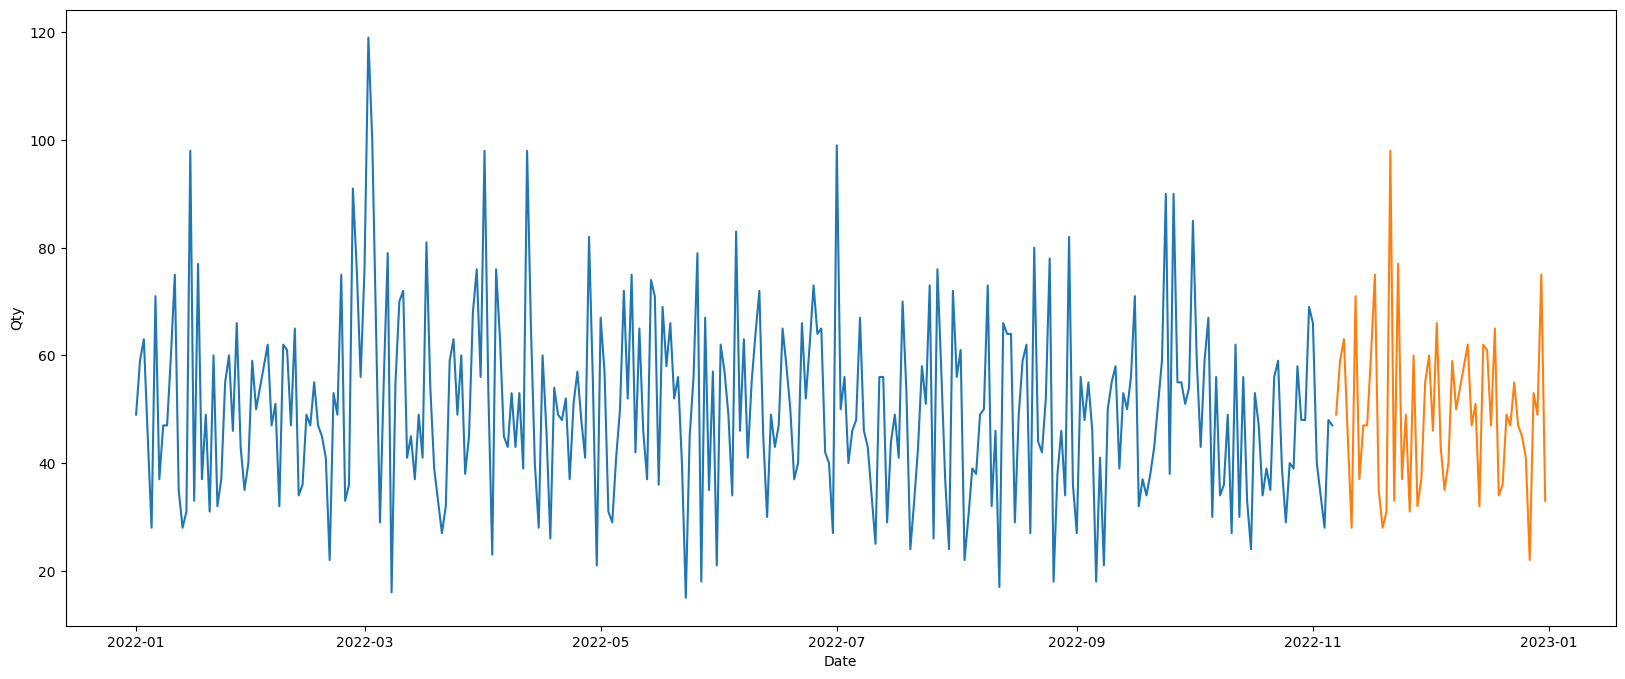

In [27]:
plt.figure(figsize =(20,8))
sns.lineplot(data = data_train, x = data_train['Date'], y = data_train['Qty'])
sns.lineplot(data = data_test, x = data_test['Date'], y = data_train['Qty'])

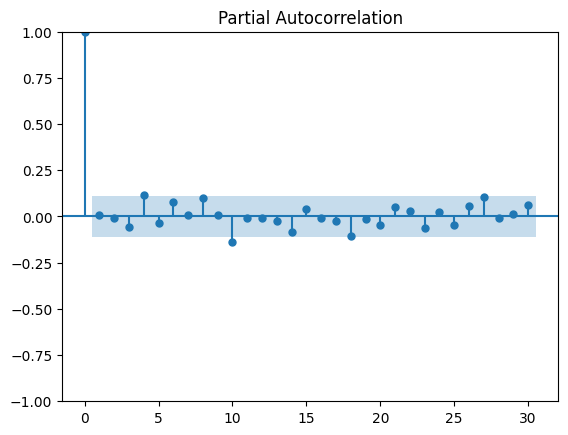

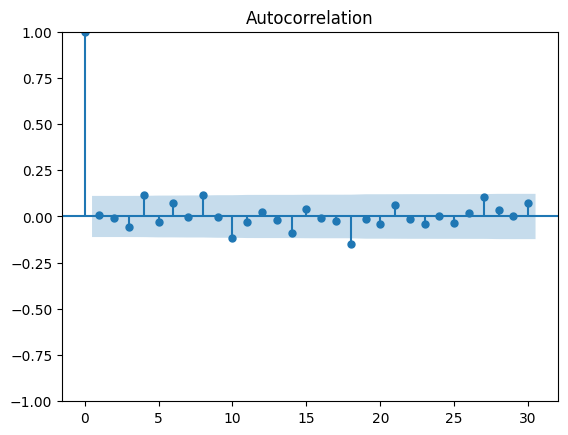

In [28]:
train_pacf = plot_pacf(data_train['Qty'], lags = 30)
train_acf = plot_acf(data_train['Qty'], lags = 30)

In [29]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings ("ignore")

stepwise_fit = auto_arima(data_train['Qty'],trace = True, 
                          suppress_warnings = True)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2646.706, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2640.415, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2642.397, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2642.396, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3344.300, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2644.395, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.525 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  310
Model:                        SARIMAX   Log Likelihood               -1318.208
Date:                Wed, 04 Oct 2023   AIC                           2640.415
Time:                        16:33:53   BIC                           2647.888
Sample:                             0   HQIC                          2643.403
          

(0.0, 100.0)

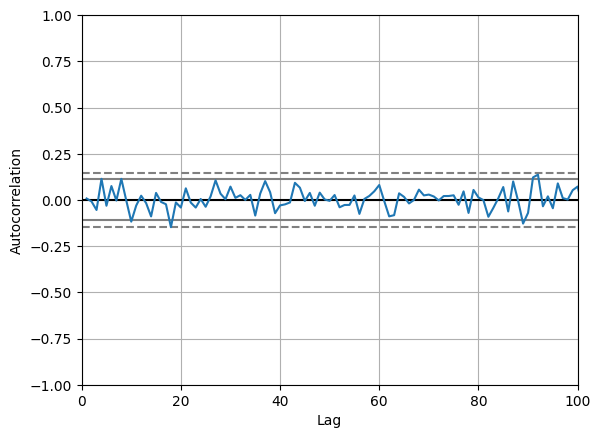

In [30]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data_train['Qty']).set_xlim([0, 100])

In [31]:
from statsmodels.tsa.arima.model import ARIMA

y = data_train['Qty']

model_1 = ARIMA(y, order = (0,0,0))
model_2 = ARIMA(y, order = (28,0,28))
model_3 = ARIMA(y, order = (44,0,44))

In [32]:
model_1 = model_1.fit()
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  310
Model:                          ARIMA   Log Likelihood               -1318.208
Date:                Wed, 04 Oct 2023   AIC                           2640.415
Time:                        16:33:53   BIC                           2647.888
Sample:                             0   HQIC                          2643.403
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2871      1.035     48.605      0.000      48.259      52.315
sigma2       289.0763     21.504     13.443      0.000     246.930     331.222
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [33]:
model_2 = model_2.fit()
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  310
Model:               ARIMA(28, 0, 28)   Log Likelihood               -1277.711
Date:                Wed, 04 Oct 2023   AIC                           2671.422
Time:                        16:34:12   BIC                           2888.143
Sample:                             0   HQIC                          2758.058
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2799      1.218     41.294      0.000      47.893      52.666
ar.L1         -0.1360      1.222     -0.111      0.911      -2.531       2.259
ar.L2          0.0798      0.525      0.152      0.8

In [34]:
model_3 = model_3.fit()
print(model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  310
Model:               ARIMA(44, 0, 44)   Log Likelihood               -1263.866
Date:                Wed, 04 Oct 2023   AIC                           2707.732
Time:                        16:35:21   BIC                           3044.024
Sample:                             0   HQIC                          2842.167
                                - 310                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2688      2.164     23.228      0.000      46.027      54.510
ar.L1          0.0653      1.081      0.060      0.952      -2.053       2.184
ar.L2          0.1793      1.129      0.159      0.8

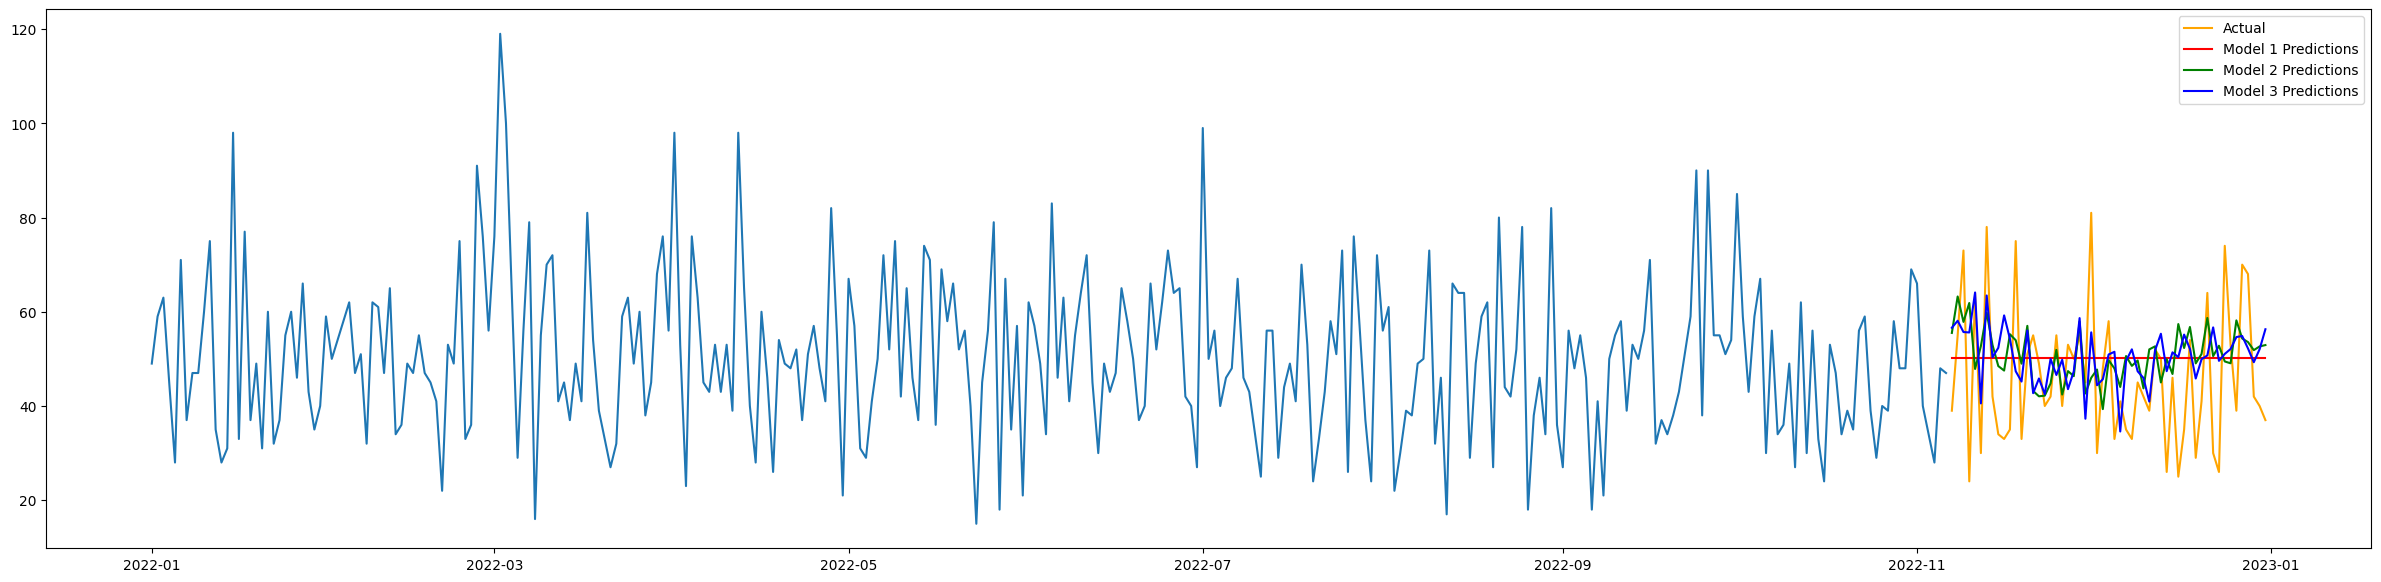

In [35]:
data_train = data_train.set_index('Date')
data_test = data_test.set_index('Date')

y_pred_1 = model_1.get_forecast(len(data_test))
y_pred_2 = model_2.get_forecast(len(data_test))
y_pred_3 = model_3.get_forecast(len(data_test))

y_pred_df_1 = y_pred_1.conf_int()
y_pred_df_1['Predictions'] = model_1.predict(start = y_pred_df_1.index[0], end = y_pred_df_1.index[-1])
y_pred_df_1.index = data_test.index
y_pred_out_1 = y_pred_df_1['Predictions']

y_pred_df_2 = y_pred_2.conf_int()
y_pred_df_2['Predictions'] = model_2.predict(start = y_pred_df_2.index[0], end = y_pred_df_2.index[-1])
y_pred_df_2.index = data_test.index
y_pred_out_2 = y_pred_df_2['Predictions']

y_pred_df_3 = y_pred_3.conf_int()
y_pred_df_3['Predictions'] = model_3.predict(start = y_pred_df_3.index[0], end = y_pred_df_3.index[-1])
y_pred_df_3.index = data_test.index
y_pred_out_3 = y_pred_df_3['Predictions']

plt.figure(figsize = (30,7))
plt.plot(data_train['Qty'])
plt.plot(data_test['Qty'], color = 'orange', label = 'Actual')
plt.plot(y_pred_out_1, color = 'red', label = 'Model 1 Predictions')
plt.plot(y_pred_out_2, color = 'green', label = 'Model 2 Predictions')
plt.plot(y_pred_out_3, color = 'blue', label = 'Model 3 Predictions')
plt.legend()

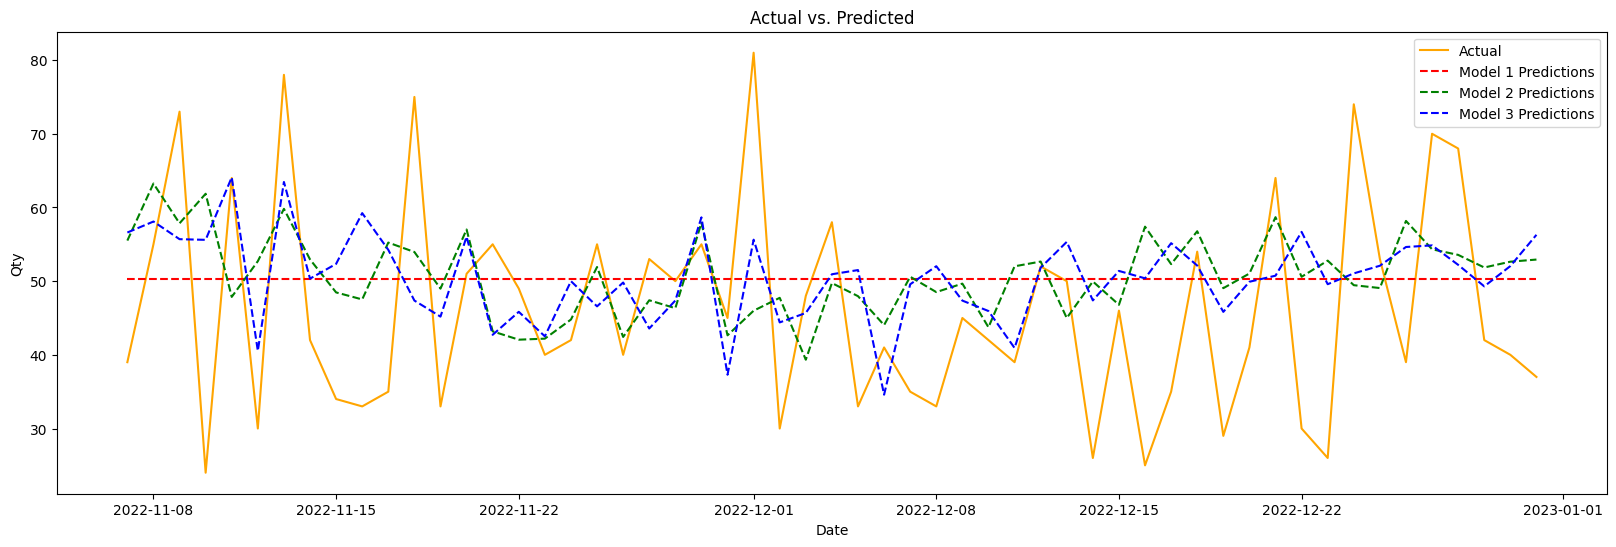

In [36]:
y_actual = data_test['Qty']

plt.figure(figsize=(20, 6))
plt.plot(data_test.index, y_actual, label = 'Actual', color = 'orange')
plt.plot(data_test.index, y_pred_out_1, label= 'Model 1 Predictions', linestyle='--', color = 'red')
plt.plot(data_test.index, y_pred_out_2, label= 'Model 2 Predictions', linestyle='--', color = 'green')
plt.plot(data_test.index, y_pred_out_3, label= 'Model 3 Predictions', linestyle='--', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.title('Actual vs. Predicted')
plt.show()

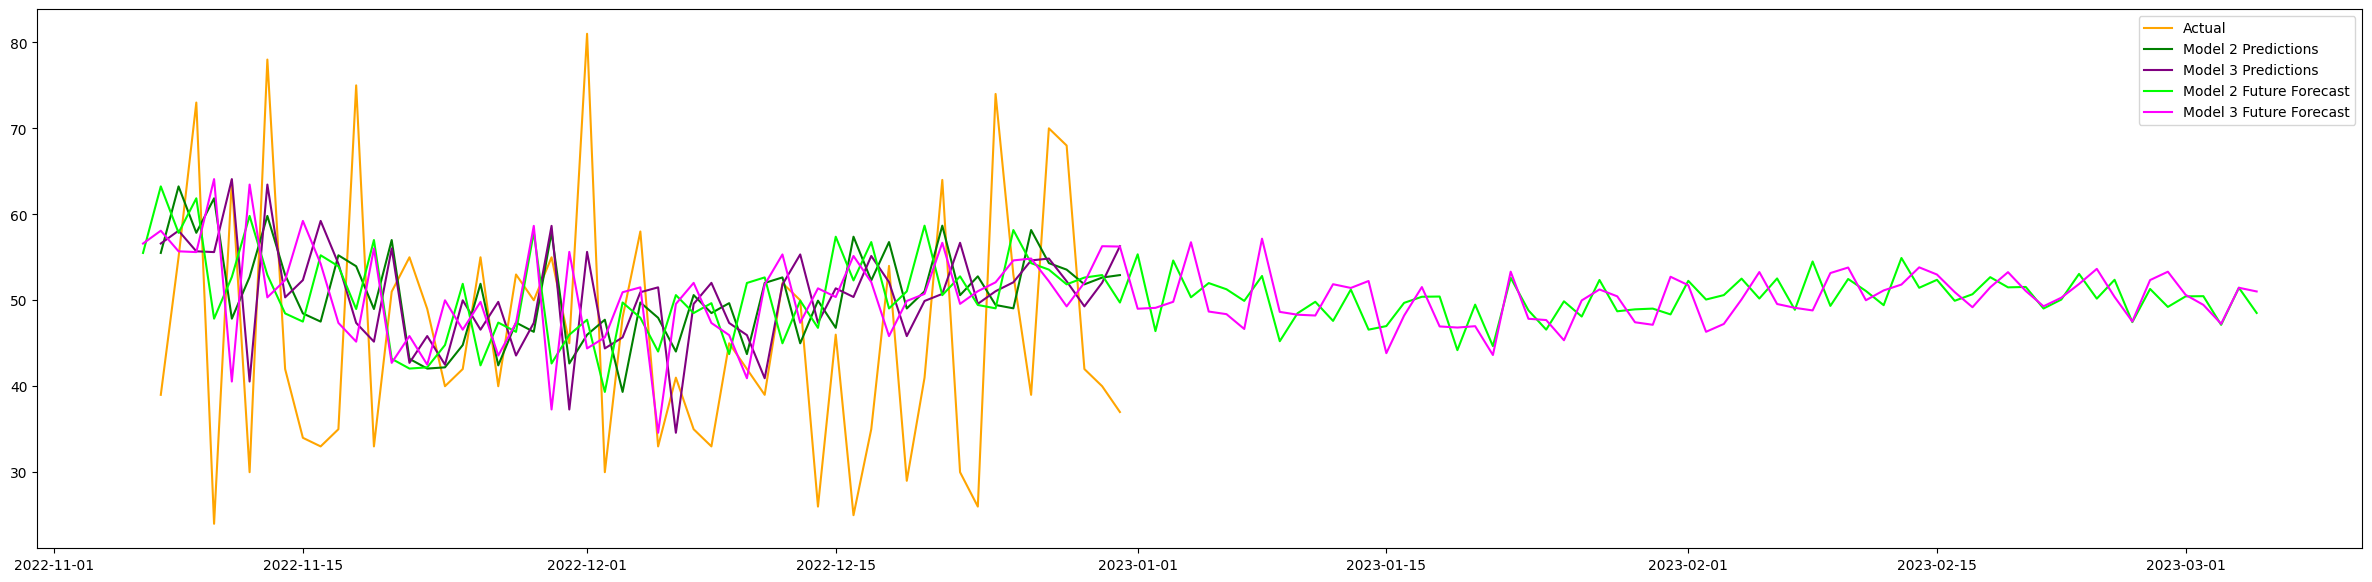

In [37]:
forecast_periods = 120 

y_pred_2_future = model_2.get_forecast(steps=forecast_periods) 
y_pred_df_2_future = y_pred_2_future.conf_int()
y_pred_df_2_future['Predictions'] = y_pred_2_future.predicted_mean
date_range = pd.date_range(start=data_train.index[-1], periods=forecast_periods)
y_pred_df_2_future.index = date_range
y_pred_out_2_future = y_pred_df_2_future['Predictions']

y_pred_3_future = model_3.get_forecast(steps=forecast_periods)
y_pred_df_3_future = y_pred_3_future.conf_int()
y_pred_df_3_future['Predictions'] = y_pred_3_future.predicted_mean
date_range = pd.date_range(start=data_train.index[-1], periods=forecast_periods)
y_pred_df_3_future.index = date_range
y_pred_out_3_future = y_pred_df_3_future['Predictions']


plt.figure(figsize=(30, 7))
plt.plot(data_test['Qty'], color='orange', label='Actual')
plt.plot(y_pred_out_2, color='green', label='Model 2 Predictions')
plt.plot(y_pred_out_3, color='purple', label='Model 3 Predictions')
plt.plot(y_pred_out_2_future, color='lime', linestyle='-', label='Model 2 Future Forecast')
plt.plot(y_pred_out_3_future, color='magenta', linestyle='-', label='Model 3 Future Forecast')
plt.legend()



In [38]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae_1 = mean_absolute_error (data_test, y_pred_out_1)
mse_1 = mean_squared_error (data_test, y_pred_out_1)
rmse_1 = np.sqrt (mean_squared_error(data_test, y_pred_out_1))
mape_1 = mean_absolute_percentage_error(data_test, y_pred_out_1)*100

mae_2 = mean_absolute_error (data_test, y_pred_out_2)
mse_2 = mean_squared_error (data_test, y_pred_out_2)
rmse_2 = np.sqrt (mean_squared_error(data_test, y_pred_out_2))
mape_2 = mean_absolute_percentage_error(data_test, y_pred_out_2)*100

mae_3 = mean_absolute_error (data_test, y_pred_out_3)
mse_3 = mean_squared_error (data_test, y_pred_out_3)
rmse_3 = np.sqrt (mean_squared_error(data_test, y_pred_out_3))
mape_3 = mean_absolute_percentage_error(data_test, y_pred_out_3)*100

print("Model 1")
print(f"Mean Absolute Error (MAE): {mae_1:.2f}")
print(f"Mean Squared Error (MSE): {mse_1:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_1:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_1:.2f}%")

print("\nModel 2")
print(f"Mean Absolute Error (MAE): {mae_2:.2f}")
print(f"Mean Squared Error (MSE): {mse_2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_2:.2f}%")

print("\nModel 3")
print(f"Mean Absolute Error (MAE): {mae_3:.2f}")
print(f"Mean Squared Error (MSE): {mse_3:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_3:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_3:.2f}%")

Model 1
Mean Absolute Error (MAE): 12.63
Mean Squared Error (MSE): 225.88
Root Mean Squared Error (RMSE): 15.03
Mean Absolute Percentage Error (MAPE): 32.07%

Model 2
Mean Absolute Error (MAE): 12.76
Mean Squared Error (MSE): 240.78
Root Mean Squared Error (RMSE): 15.52
Mean Absolute Percentage Error (MAPE): 33.23%

Model 3
Mean Absolute Error (MAE): 12.24
Mean Squared Error (MSE): 218.08
Root Mean Squared Error (RMSE): 14.77
Mean Absolute Percentage Error (MAPE): 31.72%


K-Means Clustering

In [39]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [40]:
df_clustering = df_merge.groupby(['CustomerID']).agg({
    'TransactionID':'count',
    'Qty':'sum',
    'TotalAmount':'sum'
}).reset_index()
df_clustering

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


Text(0, 0.5, 'Total Amount')

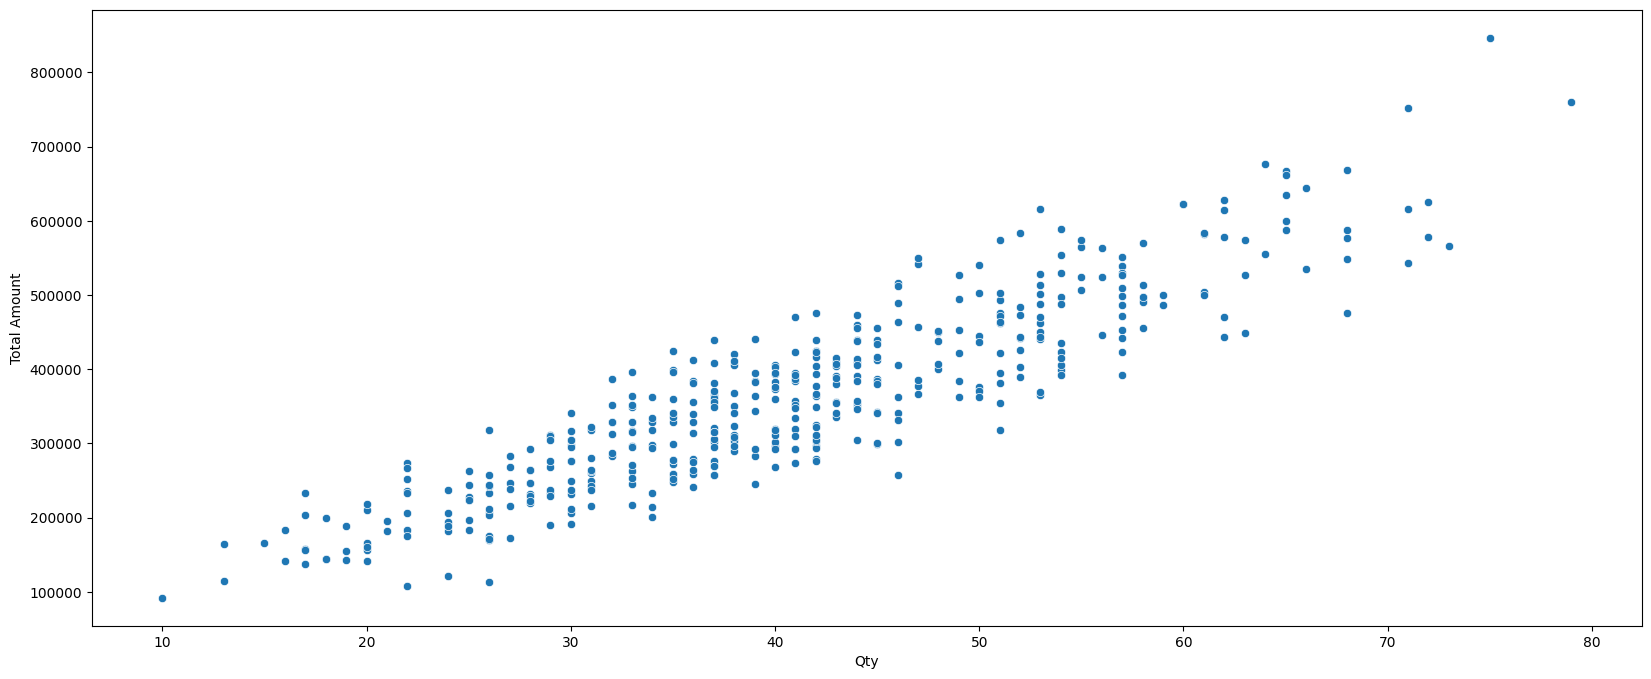

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
sns.scatterplot(data=df_clustering, x='Qty', y='TotalAmount')
plt.ylabel("Total Amount")

Data Scaling

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
temp = df_clustering.pop('CustomerID')

scaler = StandardScaler()
scaler.fit(df_clustering)
scaled_data = scaler.transform(df_clustering)
scaled_data

array([[ 1.78828224,  1.50893374,  2.10242393],
       [ 0.55344971,  1.27289149,  0.24634281],
       [ 1.17086598,  1.19421074,  0.67942841],
       ...,
       [ 2.09699037,  2.13837973,  1.81236104],
       [-0.06396655,  0.09268025,  0.49542729],
       [ 0.55344971,  0.09268025,  0.62398702]])

Method 1: Shilouette Score

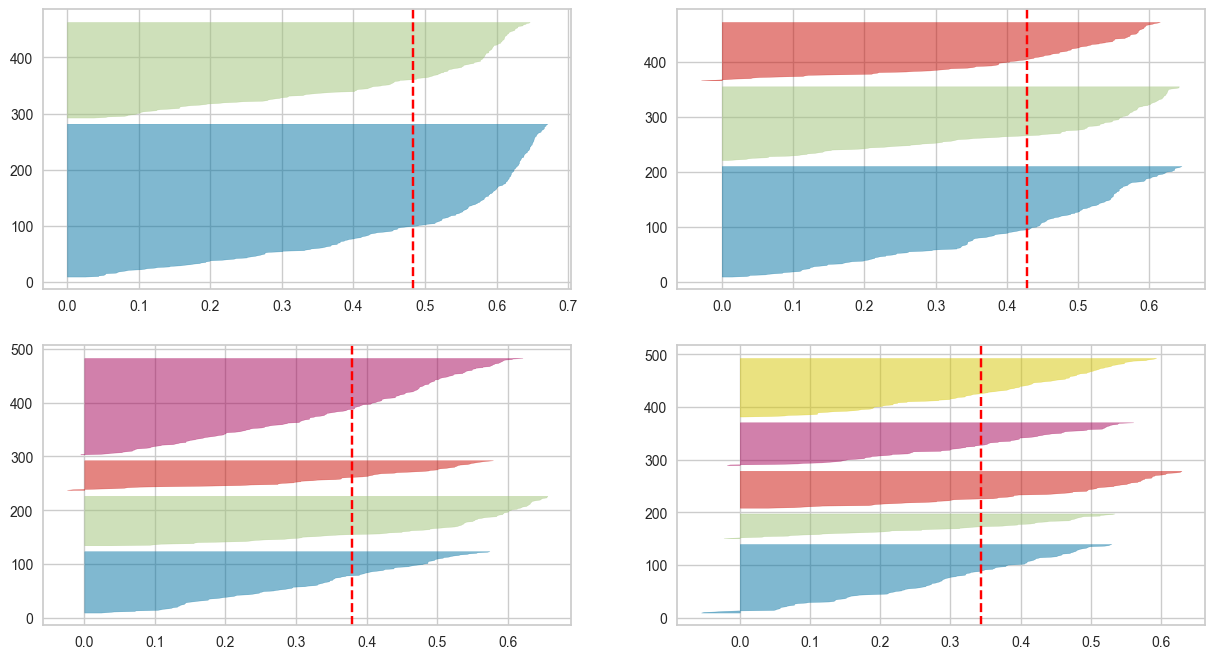

In [43]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
KS = [2, 3, 4, 5]

for k in KS:
    km = KMeans(n_clusters=k, 
                init='k-means++', 
                n_init=10, 
                max_iter=100, 
                random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, 
                                      colors='yellowbrick', 
                                      ax=ax[q-1][mod])
    visualizer.fit(scaled_data) 

In [44]:
kmeans_model = KMeans(n_clusters = 3)
kmeans_model.fit(scaled_data)

KMeans(n_clusters=3)

In [45]:
df_clustering['Cluster'] = kmeans_model.labels_
df_clustering['CustomerID'] = temp
df_clustering

,TransactionID,Qty,TotalAmount,Cluster,CustomerID
0,17,60,623300,0,1
1,13,57,392300,0,2
2,15,56,446200,0,3
3,10,46,302500,2,4
4,7,27,268600,1,5
...,...,...,...,...,...
439,13,37,269400,2,442
440,18,62,577700,0,444
441,18,68,587200,0,445
442,11,42,423300,2,446


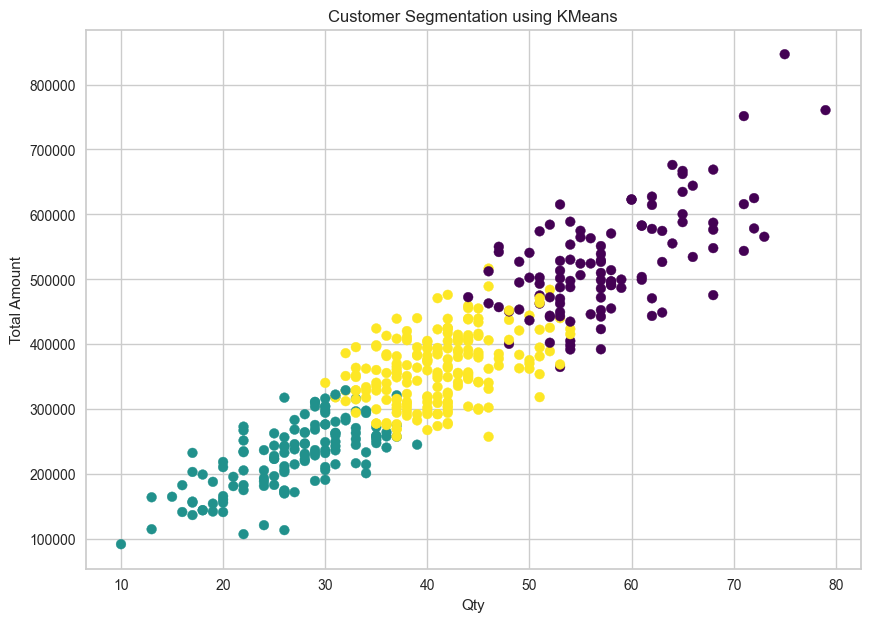

In [46]:
plt.figure(figsize = (10, 7))
plt.scatter(df_clustering['Qty'],
            df_clustering['TotalAmount'],
            c = df_clustering['Cluster'],
           cmap = 'viridis')
plt.xlabel('Qty')
plt.ylabel('Total Amount')
plt.title('Customer Segmentation using KMeans')
plt.show()

In [56]:
import plotly.express as px

fig = px.scatter_3d(df_clustering, x='Qty', y='TotalAmount', z='Cluster',
                     color='Cluster', symbol='Cluster', opacity=0.7)

fig.update_layout(scene=dict(xaxis_title='Qty',
                             yaxis_title='Total Amount',
                             zaxis_title='Cluster'),
                  title='Customer Segmentation using K-Means',
                  margin=dict(l=0, r=0, b=0, t=40))

fig.show()

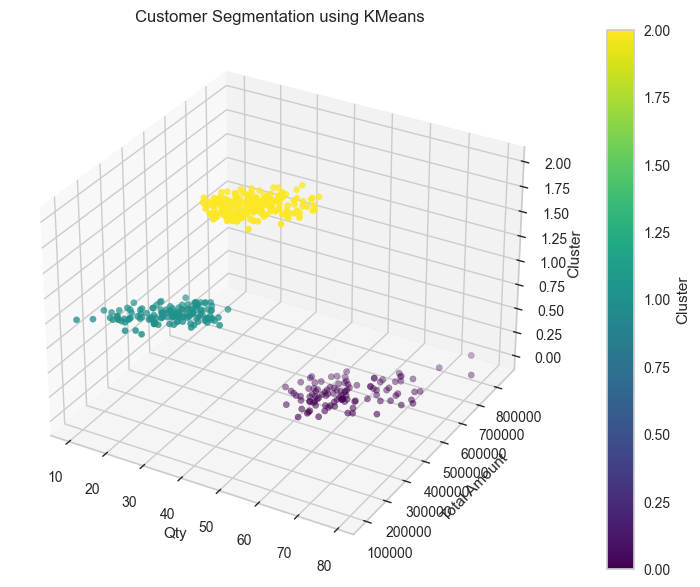

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_clustering['Qty'],
                      df_clustering['TotalAmount'],
                      df_clustering['Cluster'],
                      c=df_clustering['Cluster'], cmap='viridis')

ax.set_xlabel('Qty')
ax.set_ylabel('Total Amount')
ax.set_zlabel('Cluster')
ax.set_title('Customer Segmentation using KMeans')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()

In [57]:
cluster_stats = df_clustering.groupby(['Cluster']).agg({
    'CustomerID':'count',
    'TransactionID': ['mean', 'median'],  
    'Qty': ['mean', 'median'],            
    'TotalAmount': ['mean', 'median']     
}) 
cluster_stats

CustomerID TransactionID               Qty           TotalAmount   
             count          mean median       mean median           mean   
Cluster                                                                    
0              107     15.383178   15.0  57.654206   57.0  525431.775701  \
1              135      7.785185    8.0  26.933333   28.0  229388.888889   
2              202     11.282178   11.0  41.188119   41.0  363267.326733   

                   
           median  
Cluster            
0        512400.0  
1        235300.0  
2        362400.0

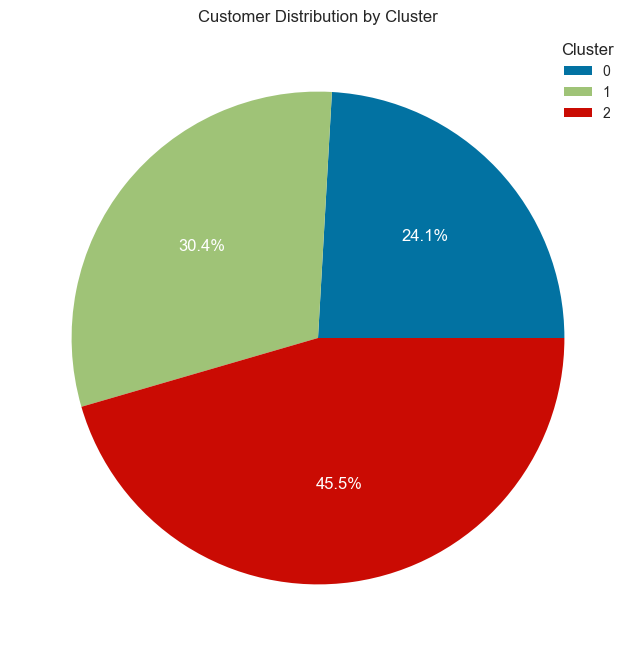

In [72]:
n_clusters = cluster_stats['CustomerID']['count']

plt.figure(figsize=(8, 8))
plt.pie(n_clusters, labels=n_clusters.index, autopct='%1.1f%%', 
        startangle=0, textprops={'color': 'white'})
plt.title('Customer Distribution by Cluster')
plt.legend(n_clusters.index, title="Cluster")
plt.show()